
# scipy.signal.spectrogram:
works by splitting the signal into (partially overlapping) segments of time, 
and then computing the power spectrum from the Fast Fourier Transform (FFT) of each segment. The 
length of these segments can be controlled using the <tt>nperseg</tt> argument, which lets you adjust the 
trade-off between resolution in the frequency and time domains that arises due to the <i>uncertainty 
principle</i>. Making <tt>nperseg</tt> larger gives you more resolution in the frequency domain at the cost of 
less resolution in the time domain.

In addition to varying the number of samples that go into each segment, it's also sometimes desirable 
to apply zero-padding to each segment before taking its FFT. This is what the <tt>nfft</tt> argument is for:

## nfft : int, optional

    Length of the FFT used, if a zero padded FFT is desired. If None, the FFT length is nperseg. 
    Defaults to None.

By default, <tt>nfft == nperseg</tt>, meaning that no zero-padding will be used.

The relationship between nperseg and the number of time bins (i.e. columns) in the output array also depends on the degree of overlap between the segments. By default, <tt>noverlap = nperseg // 8</tt>, so for an input of length n you will get <tt>n // (nperseg - (nperseg // 8))</tt> time bins. The number of frequency bins will be equal to the length of the real-valued DFT of each zero-padded segment (the same size as the result of np.fft.rfft(zero_padded_segment)), which is equal to nfft // 2 + 1.

If <tt>nfft</tt> is not None then it must be <tt>>= nperseg</tt>, and <tt>nfft - nperseg</tt> is the length of zero padding applied to each segment before taking the FFT. 

# Examples

https://pythontic.com/visualization/signals/spectrogram

https://notebook.community/JoseGuzman/myIPythonNotebooks/SignalProcessing/EEG%20Spectrogram



In [18]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [11]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

notch_filter=0
band_pass=0
mean_center=0

not_number_count=0
number_count=np.zeros(10)

with open('data/EP1_01.txt') as f:
    lines = f.readlines()
  
for ii in range(0,1000):
    #print(lines[0], "\n")

    fields = lines[ii].split("\t")
    header = fields[0:5]

    digit= float(header[4])
    opt = header[3]
    
    if opt != 'P7':
        continue
        
    if digit < 0:
        not_number_count += 1
        continue
    else:
        number_count[int(digit)] += 1
        
    
    #print(header,'\n')
    eeg=fields[6:]
    eeg=eeg[0]
        
    eeg= np.fromstring(eeg, dtype=float, sep=',')
    
    if len(eeg) < 250:
        continue
       
    eeg=eeg[0:250]
    #eeg=np.around(eeg, decimals=0)
    
    
    if notch_filter:    
        samp_freq = 128       # Sample frequency (Hz)
        notch_freq = 50.0     # Frequency to be removed from signal (Hz)
        quality_factor = 20.0 # Quality factor
        # Design a notch filter using signal.iirnotch
        b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
        
        # Compute magnitude response of the designed filter
        freq, h = signal.freqz(b_notch, a_notch, fs=samp_freq)
    
        # Apply notch filter to the noisy signal using signal.filtfilt
        eeg = signal.filtfilt(b_notch, a_notch, eeg)
        
    if band_pass:
        fs=128
        lo_fc = 3  # Cut-off frequency of the filter
        hi_fc = 30
        lo_w = lo_fc / (fs/2) # Normalize the frequency by the Nyquist frequency
        hi_w = hi_fc / (fs/2)
        b, a = signal.butter(2, [lo_w, hi_w], 'band', analog=False)
        eeg = signal.filtfilt(b, a, eeg)        
    if mean_center:
        eeg = eeg - (sum(eeg)/len(eeg))

    
    if random.random() < 0.80:
        x_train.append(eeg)
        y_train.append(int(digit))
    else:
        x_test.append(eeg)
#         one_hot = np.zeros(10)  # done below
#         one_hot[int(digit)]=1
        y_test.append(int(digit))  

In [13]:
print("length of eeg=", len(eeg))
print("number of exampes in data set=",len(lines))
print("P7 training count =", len(x_train))
print("P7 testing count =", len(x_test))
print("not number count=", not_number_count)
print("number count=", number_count)

length of eeg= 250
number of exampes in data set= 910476
P7 training count = 56
P7 testing count = 16
not number count= 0
number count= [ 6. 11.  7.  9.  2.  5.  7.  6. 11.  8.]


In [14]:
xxx_train = np.array(x_train)
y_train = np.array(y_train)

xxx_test = np.array(x_test)
y_test = np.array(y_test)

In [15]:
x_train=xxx_train.reshape(xxx_train.shape[0], xxx_train.shape[1],1)
# #x_train=x_train / 255.0
x_test = xxx_test.reshape(xxx_test.shape[0], xxx_test.shape[1],1)
# #x_test=x_test/255.0

In [39]:
y=x_train[1].flatten()
eeg=np.concatenate((y,y,y,y))   # y is EEG data, Fs 128 Hz, only about 250 points long, so can concat

eeg = eeg - np.mean(eeg)        # if don't subtract mean, get flat line Power Spectrum (below)


# Welch's periodogram

In [40]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  


sr = 128  # sampling rate

# compute frequencies vector until half the sampling rate
Nyquist = sr/2

print('Nyquist frequency = %2.4f Hz'%Nyquist)
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 64.0000 Hz
Spectral resolution = 0.1280 Hz


In [41]:
# Nyquist frequency = 512.0000 Hz
# Spectral resolution = 0.0083 Hz

In [42]:
# Perform Welch's periodogram
segment = int( 4*sr ) 
myhann = signal.get_window('hann', segment)

# obtain the power (uV^2) spectrum with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps

# obtain the power density/Hz (uV^2) spectrum with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                 scaling = 'density', return_onesided = True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2/Hz
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


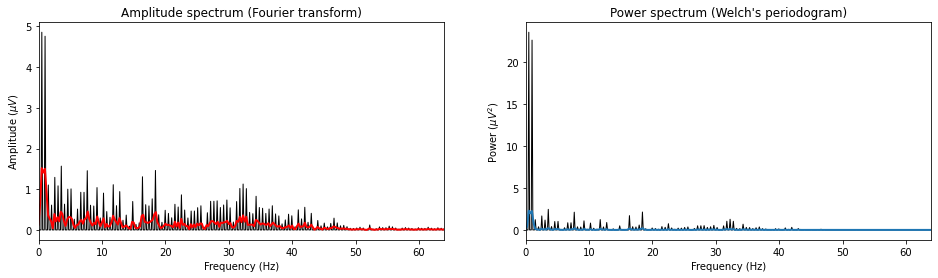

In [46]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].plot(hz,amp[:len(hz)], lw=1, color='k')#, use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps/10), color='red', lw=2) 
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(hz, np.power(amp[:len(hz)],2), color='k', lw =1)
ax[1].plot(freq, (ps/10), color='C0', lw=2)#, use_line_collection = True)
ax[1].set_ylabel('Power ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,64)
    myticks = list(range(0,64,10))
    myax.set_xticks(myticks)
    #myax.set_ylim(ymax=2)

In [47]:
eeg.shape

(1000,)

# spectrogram